In [66]:
# Random acts of pizza (RAOP) competition

%matplotlib inline
import json
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [41]:
# First, get the training and test data (in JSON) 

# Mac path
#f = open(os.path.expanduser("~/Google Drive/UCB_MIDS_StartingSummer2014/2015_Spring/W207_ItML/FinalProject/train.json"))
#trainset = pd.read_json(f)

# Windows
jsonloc = r'C:\Users\Murat Aydogdu\Google Drive\UCB_MIDS_StartingSummer2014\2015_Spring\W207_ItML\FinalProject\train.json'
trainset = pd.read_json(jsonloc)
jsonloc = r'C:\Users\Murat Aydogdu\Google Drive\UCB_MIDS_StartingSummer2014\2015_Spring\W207_ItML\FinalProject\test.json'
testset = pd.read_json(jsonloc)

print trainset.giver_username_if_known.value_counts()
train = pd.DataFrame(trainset)
test = pd.DataFrame(testset)
print list(train.columns.values)

print train.head()
print train.info()

N/A                     3753
jetboyterp                 5
johngalt1337               4
thr                        4
mr_jeep                    4
m2nu                       4
leftnewdigg                3
pizzamom                   3
glinda_da_good_witch       3
zandyman                   2
whosthatguru_v2            2
harrisonfire               2
olivertw1st                2
psm321                     2
jabberworx                 2
...
better_with_salt    1
hungrytrex          1
jeffreyed           1
pookie85            1
my2penniesworth     1
thedanindanger      1
omnomagon           1
raxxarn             1
odd-one-out         1
maverick44          1
scott2chicago       1
goodgodamighty      1
juggalofx           1
tableofgeeks        1
raopanon            1
Length: 250, dtype: int64
[u'giver_username_if_known', u'number_of_downvotes_of_request_at_retrieval', u'number_of_upvotes_of_request_at_retrieval', u'post_was_edited', u'request_id', u'request_number_of_comments_at_retrieval', u'r

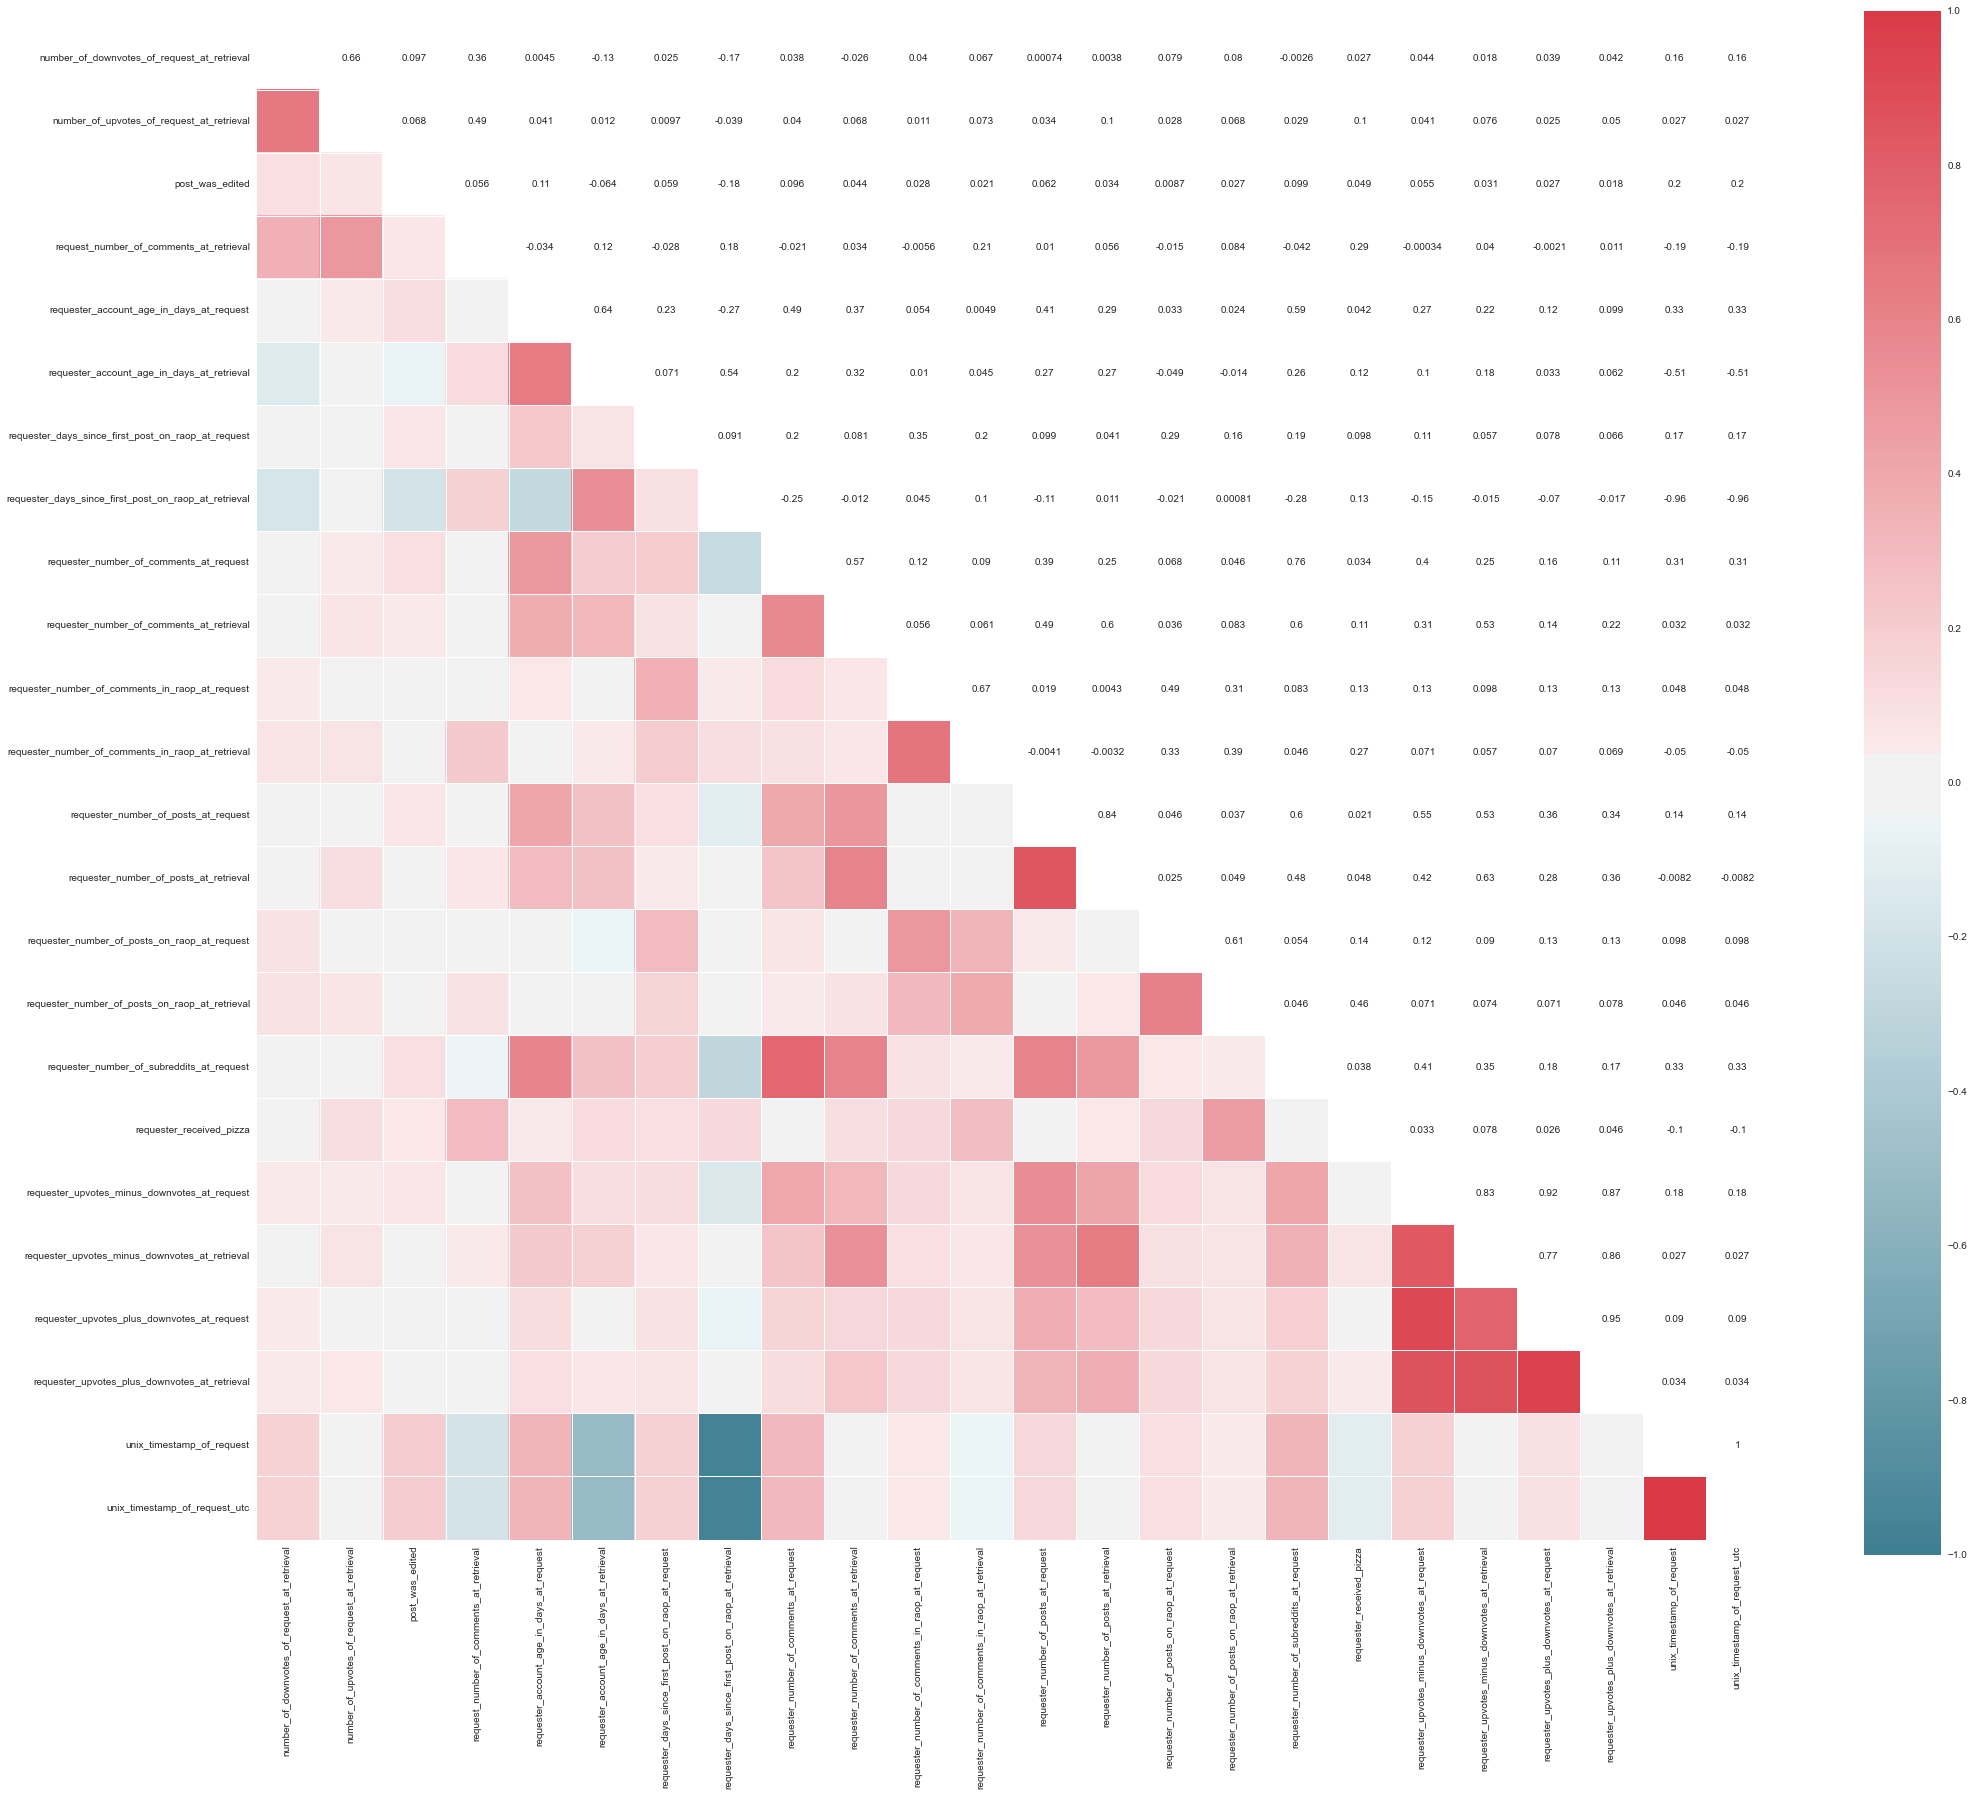

In [42]:
# Correlation heatmap for all features including those that do not appear in the test set
train_data_names = list(train.columns.values)
fig, ax = plt.subplots(figsize=(30, 30), dpi=80)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.corrplot(train, names=train_data_names, annot=True, sig_stars=False,
             diag_names=False, cmap=cmap, ax=ax)
fig.tight_layout()

In [43]:
# TRAINING SET
# Convert numeric variables to binary where appropriate
# Convert numeric variables to normalized where appropriate

def binarize(A):
    return A.map(lambda x: 1 if x > 0 else 0)

def standardize(A):
    mn = np.mean(A)
    sd = np.std(A)
    return (A-mn)/sd

#print train.info()
train['bin_ncom_req'] = binarize(train['requester_number_of_comments_at_request'])
train['bin_ncom_raop_req'] = binarize(train['requester_number_of_comments_in_raop_at_request'])
train['bin_posts_req'] = binarize(train['requester_number_of_posts_at_request'])
train['bin_posts_raop_req'] = binarize(train['requester_number_of_posts_on_raop_at_request'])
train['bin_subr_req'] = binarize(train['requester_number_of_subreddits_at_request'])
train['bin_upminusdown_req'] = binarize(train['requester_upvotes_minus_downvotes_at_request'])
train['bin_upplusdown_req'] = binarize(train['requester_upvotes_plus_downvotes_at_request'])

train['std_ncom_req'] = standardize(train['requester_number_of_comments_at_request'])
train['std_ncom_raop_req'] = standardize(train['requester_number_of_comments_in_raop_at_request'])
train['std_posts_req'] = standardize(train['requester_number_of_posts_at_request'])
train['std_posts_raop_req'] = standardize(train['requester_number_of_posts_on_raop_at_request'])
train['std_subr_req'] = standardize(train['requester_number_of_subreddits_at_request'])
train['std_upminusdown_req'] = standardize(train['requester_upvotes_minus_downvotes_at_request'])
train['std_upplusdown_req'] = standardize(train['requester_upvotes_plus_downvotes_at_request'])

# From the request timestamp, extract hour of the day, whether it's the first half of the month,
# and weekday
tmx = train['unix_timestamp_of_request']
tm2 = np.zeros(len(tmx))
tm3 = np.zeros(len(tmx))
tm4 = np.zeros(len(tmx))
for i in range(len(tmx)):
    z = datetime.datetime.utcfromtimestamp(tmx[i])
    tm2[i] = datetime.datetime.strftime(z, "%H")
    tmday = int(datetime.datetime.strftime(z, "%d"))
    if tmday < 15:
        tm3[i] = 1
    tm4[i] = datetime.datetime.strftime(z, "%w") # Day of the week (Sunday is 0, 0..6)    
    
train['timestamp'] = tm2
train['mon_firsthalf'] = tm3
train['weekday'] = tm4
    
# Text: get length and search for some keywords from Althoff et al Table 1    
tmx = train['request_text_edit_aware']

tm2 = np.zeros(len(tmx))
tm3 = np.zeros(len(tmx))
words = ['money','check','work','bill','job','food','school','thanks','student','class','favor','friend']
for i in range(len(tmx)):
    z = tmx[i].lower()
    tm2[i] = len(z)
    if any(k in z for k in words):
        tm3[i] = 1

train['req_length'] = tm2 
train['req_wordexists'] = tm3

In [44]:
# TEST SET
# Convert numeric variables to binary where appropriate
# Convert numeric variables to normalized where appropriate

def binarize(A):
    return A.map(lambda x: 1 if x > 0 else 0)

def standardize(A):
    mn = np.mean(A)
    sd = np.std(A)
    return (A-mn)/sd

#print test.info()
test['bin_ncom_req'] = binarize(test['requester_number_of_comments_at_request'])
test['bin_ncom_raop_req'] = binarize(test['requester_number_of_comments_in_raop_at_request'])
test['bin_posts_req'] = binarize(test['requester_number_of_posts_at_request'])
test['bin_posts_raop_req'] = binarize(test['requester_number_of_posts_on_raop_at_request'])
test['bin_subr_req'] = binarize(test['requester_number_of_subreddits_at_request'])
test['bin_upminusdown_req'] = binarize(test['requester_upvotes_minus_downvotes_at_request'])
test['bin_upplusdown_req'] = binarize(test['requester_upvotes_plus_downvotes_at_request'])

test['std_ncom_req'] = standardize(test['requester_number_of_comments_at_request'])
test['std_ncom_raop_req'] = standardize(test['requester_number_of_comments_in_raop_at_request'])
test['std_posts_req'] = standardize(test['requester_number_of_posts_at_request'])
test['std_posts_raop_req'] = standardize(test['requester_number_of_posts_on_raop_at_request'])
test['std_subr_req'] = standardize(test['requester_number_of_subreddits_at_request'])
test['std_upminusdown_req'] = standardize(test['requester_upvotes_minus_downvotes_at_request'])
test['std_upplusdown_req'] = standardize(test['requester_upvotes_plus_downvotes_at_request'])

# From the request timestamp, extract hour of the day, whether it's the first half of the month,
# and weekday
tmx = test['unix_timestamp_of_request']
tm2 = np.zeros(len(tmx))
tm3 = np.zeros(len(tmx))
tm4 = np.zeros(len(tmx))
for i in range(len(tmx)):
    z = datetime.datetime.utcfromtimestamp(tmx[i])
    tm2[i] = datetime.datetime.strftime(z, "%H")
    tmday = int(datetime.datetime.strftime(z, "%d"))
    if tmday < 15:
        tm3[i] = 1
    tm4[i] = datetime.datetime.strftime(z, "%w") # Day of the week (Sunday is 0, 0..6)    
    
test['timestamp'] = tm2
test['mon_firsthalf'] = tm3
test['weekday'] = tm4
    
# Text: get length and search for some keywords from Althoff et al Table 1    
tmx = test['request_text_edit_aware']

tm2 = np.zeros(len(tmx))
tm3 = np.zeros(len(tmx))
words = ['money','check','work','bill','job','food','school','thanks','student','class','favor','friend']
for i in range(len(tmx)):
    z = tmx[i].lower()
    tm2[i] = len(z)
    if any(k in z for k in words):
        tm3[i] = 1

test['req_length'] = tm2 
test['req_wordexists'] = tm3


In [55]:
# All of the data to be used in analysis: response followed by features in one array
# Remove the response variable from the data set
# Remove any variable that is not going to be used from the dataset
# all_data.drop('requester_received_pizza', axis=1, inplace=True)
# Training set and test set should look alike

print train.info()
newtrain = train.iloc[:,[9,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]]
print test.info()
newtest = test.iloc[:,[4,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]]

#newtrain = train.iloc[:,[3,9,11,13,15,17,19,21,24,26,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47]]
#print newtrain.info()
Y = train.requester_received_pizza.astype(int)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 51 columns):
giver_username_if_known                                 4040 non-null object
number_of_downvotes_of_request_at_retrieval             4040 non-null int64
number_of_upvotes_of_request_at_retrieval               4040 non-null int64
post_was_edited                                         4040 non-null int64
request_id                                              4040 non-null object
request_number_of_comments_at_retrieval                 4040 non-null int64
request_text                                            4040 non-null object
request_text_edit_aware                                 4040 non-null object
request_title                                           4040 non-null object
requester_account_age_in_days_at_request                4040 non-null float64
requester_account_age_in_days_at_retrieval              4040 non-null float64
requester_days_since_first_post_on_raop_at_reque

In [77]:
# In 1.13.5. Tree-based feature selection
# Tree-based estimators (see the sklearn.tree module and 
# forest of trees in the sklearn.ensemble module) 
# can be used to compute feature importances, 
# which in turn can be used to discard irrelevant features:
X = newtrain.as_matrix()
print list(newtrain.columns.values) 
#print X
clf = ExtraTreesClassifier()
X_new = clf.fit(X, Y).transform(X)
print clf.feature_importances_  
print X_new.shape

[u'requester_account_age_in_days_at_request', 'bin_ncom_req', 'bin_ncom_raop_req', 'bin_posts_req', 'bin_posts_raop_req', 'bin_subr_req', 'bin_upminusdown_req', 'bin_upplusdown_req', 'std_ncom_req', 'std_ncom_raop_req', 'std_posts_req', 'std_posts_raop_req', 'std_subr_req', 'std_upminusdown_req', 'std_upplusdown_req', 'timestamp', 'mon_firsthalf', 'weekday', 'req_length', 'req_wordexists']
[ 0.0841371   0.00808612  0.00925877  0.007189    0.00311211  0.00055783
  0.0040907   0.00065877  0.07757421  0.02075428  0.06870258  0.00369607
  0.07944038  0.08634811  0.08830428  0.13517973  0.00666031  0.09553077
  0.20146769  0.01925118]
(4040L, 9L)


In [80]:
# Note: X_new is the reduced set of features
# X = np.delete(X,[1,3,5], 1) # First delete the last column

print X_new

# Shuffle X and Y 
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X_new[shuffle], Y[shuffle]
#X, Y = X[shuffle], Y[shuffle]

# Split X and Y into training and test sets.
train_data, train_labels = X[:3000], Y[:3000]
test_data, test_labels = X[3000:], Y[3000:]
print train_data.dtype, train_labels.dtype
print test_data.dtype, test_labels.dtype

[[  0.00000000e+00  -5.95453804e-01  -4.24484404e-01 ...,   2.20000000e+01
    3.00000000e+00   3.16000000e+02]
 [  5.01111100e+02  -5.95453804e-01  -1.29723835e-01 ...,   5.00000000e+00
    0.00000000e+00   7.40000000e+01]
 [  0.00000000e+00  -5.95453804e-01  -4.24484404e-01 ...,   1.70000000e+01
    3.00000000e+00   2.77000000e+02]
 ..., 
 [  4.10551736e+02  -2.79874057e-01  -3.06580176e-01 ...,   1.50000000e+01
    2.00000000e+00   2.63000000e+02]
 [  0.00000000e+00  -5.95453804e-01  -4.24484404e-01 ...,   1.50000000e+01
    1.00000000e+00   3.02000000e+02]
 [  5.72314942e+02   2.11025452e+00  -3.14703116e-02 ...,   2.20000000e+01
    0.00000000e+00   2.96000000e+02]]
float64 int32
float64 int32


[[ 0.00031838  0.01495812 -0.02884764  0.02616341 -0.03513976  0.12628617
   0.00192922 -0.02651203  0.0007014 ]]
             precision    recall  f1-score   support

          0       0.75      1.00      0.85       776
          1       0.40      0.01      0.01       264

avg / total       0.66      0.75      0.64      1040

[[773   3]
 [262   2]]
Classification accuracy: 0.745192307692
0.253846153846


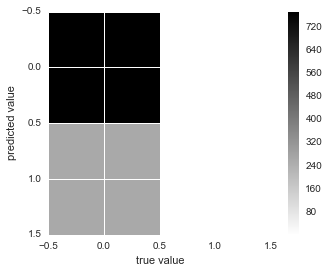

In [82]:
#logReg = LogisticRegression(C=1, penalty='l2')
logReg = LogisticRegression(C=1, penalty='l1')
logReg.fit(train_data, train_labels)  
print(logReg.coef_)
# Make predictions on the test data
expected = test_labels
predicted = logReg.predict(test_data)
# Summarize the fit of the model
print(classification_report(expected, predicted))
print(confusion_matrix(expected, predicted))
print "Classification accuracy:", metrics.accuracy_score(expected, predicted)
print expected.mean()
plt.imshow(confusion_matrix(expected, predicted),
               cmap=plt.cm.binary, interpolation='nearest')
plt.colorbar()
plt.xlabel('true value')
plt.ylabel('predicted value')


In [83]:
k_values = [1, 3, 5, 7, 9]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)    
    knn.fit(train_data, train_labels) # Use the mini training set     
    expected = test_labels                       
    predicted = knn.predict(test_data)           # Test the model using the development set 
    correct = expected == predicted             # How many of the digits were correctly predicted?
    if k == 1:
        print(knn)  # Print the parameters of the KNN classifier used 
        print("\n") 
        print(classification_report(expected, predicted))
        print("\n")
        # In the classification report, with T/F = true/false and P/N = positive/negative
        # precision = TP / (TP + FP) and recall = TP / (TP + FN)
        # f1-score is the harmonic mean of the two numbers (higher = better performance)
        # and support is the number of observations
    print 'K:%3d total: %3d correct: %3d accuracy: %3.2f' %(k, len(correct), np.sum(correct), metrics.accuracy_score(expected, predicted))
 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform')


             precision    recall  f1-score   support

          0       0.76      0.75      0.75       776
          1       0.28      0.28      0.28       264

avg / total       0.64      0.63      0.64      1040



K:  1 total: 1040 correct: 660 accuracy: 0.63
K:  3 total: 1040 correct: 718 accuracy: 0.69
K:  5 total: 1040 correct: 737 accuracy: 0.71
K:  7 total: 1040 correct: 748 accuracy: 0.72
K:  9 total: 1040 correct: 761 accuracy: 0.73


Total: 1040 correct: 675 accuracy: 0.65
             precision    recall  f1-score   support

          0       0.76      0.77      0.77       776
          1       0.31      0.30      0.30       264

avg / total       0.65      0.65      0.65      1040

[[596 180]
 [185  79]]
Classification accuracy: 0.649038461538
0.253846153846


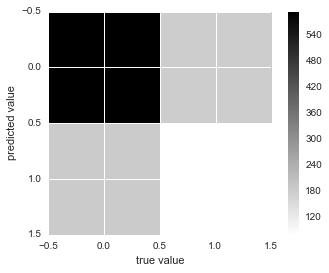

In [84]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_labels)
expected = test_labels 
predicted = clf.predict(test_data)          
correct = expected == predicted  
print 'Total: %3d correct: %3d accuracy: %3.2f' %(len(correct), np.sum(correct), metrics.accuracy_score(expected, predicted))
print(classification_report(expected, predicted))
print(confusion_matrix(expected, predicted))
print "Classification accuracy:", metrics.accuracy_score(expected, predicted)
print expected.mean()
plt.imshow(confusion_matrix(expected, predicted),
               cmap=plt.cm.binary, interpolation='nearest')
plt.colorbar()
plt.xlabel('true value')
plt.ylabel('predicted value') 

Total: 1040 correct: 758 accuracy: 0.73
             precision    recall  f1-score   support

          0       0.75      0.95      0.84       776
          1       0.33      0.06      0.11       264

avg / total       0.64      0.73      0.65      1040

[[741  35]
 [247  17]]
Classification accuracy: 0.728846153846
0.253846153846


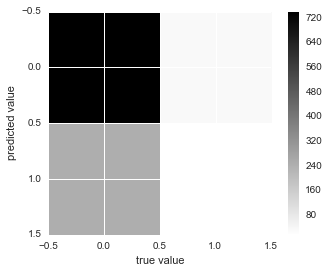

In [85]:
# Create the random forest object which will include all the parameters for the fit
forest = RandomForestClassifier(n_estimators = 100)

# Fit the training data to the Survived labels and create the decision trees
forest = forest.fit(train_data,train_labels)
expected = test_labels 
predicted = forest.predict(test_data)          
correct = expected == predicted  
print 'Total: %3d correct: %3d accuracy: %3.2f' %(len(correct), np.sum(correct), metrics.accuracy_score(expected, predicted))
print(classification_report(expected, predicted))
print(confusion_matrix(expected, predicted))
print "Classification accuracy:", metrics.accuracy_score(expected, predicted)
print expected.mean()
plt.imshow(confusion_matrix(expected, predicted),
               cmap=plt.cm.binary, interpolation='nearest')
plt.colorbar()
plt.xlabel('true value')
plt.ylabel('predicted value') 
